In [1]:
#import scipy.sparse as sps
from sklearn.linear_model import LogisticRegression	

import scipy.io
import numpy as np
from scipy import linalg as LA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#from keras import optimizers
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from scipy.signal import butter,lfilter
#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
#from keras import regularizers
#from keras import losses
from keras import optimizers
import sklearn.feature_selection
from sklearn.feature_selection import mutual_info_classif
#from keras.layers.normalization import BatchNormalization
#from keras.layers.core import Dense,Dropout,Activation,Lambda
##from pyglmnet import GLM #change pwd to E:\Brain Machine\Thesis\Potential datasets\BCI Competition 2008 – Graz data set B\pyglmnet-master
#import matplotlib.pyplot as plt
import random
random.seed(1)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Classifier

In [2]:
def lda(feat_train,labels_train,feat_test):
#    print("\nLinear Discriminant Analysis")
    clf=LinearDiscriminantAnalysis()
    clf.fit(feat_train,labels_train)
    pred_train=clf.predict(feat_train)
    pred_test=clf.predict(feat_test)
    return pred_train,pred_test    

def neural_net(feat_train,ltrain,feat_test,neuron):
    ltrain=np.array(ltrain)
    ltrain[np.where(ltrain==1)]=0
    ltrain[np.where(ltrain==2)]=1
#    print("\nSingle layered Feedforward neural network with %d neurons"%neuron)
    model=Sequential()
    model.add(Dense(100,input_dim=np.shape(feat_train)[1],
                activation='sigmoid',kernel_initializer='uniform'))
    #model.add(Dropout(0.05))
    #model.add(BatchNormalization())
#    model.add(Dense(50,activation='sigmoid',kernel_initializer='uniform'))
    ##model.add(BatchNormalizafrom keras.layers import Densetion())
    model.add(Dense(90,activation='sigmoid',kernel_initializer='uniform'))
    model.add(Dense(15,activation='sigmoid',kernel_initializer='uniform'))
    model.add(Dense(1,activation='sigmoid',kernel_initializer='uniform'))
    #optim=optimizers.SGD(lr=0.0001)
    model.compile(loss='mean_squared_error',optimizer=optimizers.adam(lr=0.0001),metrics=['accuracy'])
    model.fit(feat_train,ltrain,verbose=0)

    pred_train=(model.predict(feat_train))
    
    pred_test=(model.predict(feat_test))
    return pred_train,pred_test


#train_error=np.mean(labels_train!=np.array(pred_train))
#print("train error:",train_error)
def naive_bayes(feat_train,y_train,feat_test):
    gnb=GaussianNB()
    pred_train=gnb.fit(feat_train,y_train).predict(feat_train)
    pred_test=gnb.fit(feat_train,y_train).predict(feat_test)
    return pred_train,pred_test

def KNN(feat_train,y_train,feat_test,neighbor):
#    print("\n%d-Nearest neighbor" % neighbor)
    neigh = KNeighborsClassifier(n_neighbors=neighbor)
    neigh.fit(feat_train, y_train)
    pred_train=neigh.predict(feat_train)
    pred_test=neigh.predict(feat_test)
    return pred_train,pred_test

def log_reg(feat_train,y_train,feat_test):
#    print("\nLogistic regression")
    clf=LogisticRegression(random_state=0,solver='liblinear',multi_class='ovr').fit(feat_train,y_train)
    pred_train=clf.predict(feat_train)  
    pred_test=clf.predict(feat_test)    
    return pred_train,pred_test

def boost(feat_train,y_train,feat_test,depth):
#    print("\nXGBOOST max_depth:",depth)
#    clf=xgb.XGBClassifier(max_depth,min_child_weight=1,n_estimators=1000)
#    dtrain=xgb.DMatrix(features_train,labels_train)
    clf=xgb.XGBClassifier(depth=depth,
                seed= 0, #for reproducibility
                silent= 1,
                learning_rate= 0.05,
                n_estimators= 500)
    clf.fit(feat_train,y_train,verbose=False)
    pred_train=clf.predict(feat_train)
    pred_test=clf.predict(feat_test)
    return pred_train,pred_test

def random_forest(feat_train,labels_train,feat_test,depth):
#    print("\nRandom forest with max depth:",depth)

    model=RandomForestClassifier(
          max_depth=depth,random_state=0,n_estimators=1500)
    #      min_samples_leaf=10,
    #      min_weight_fraction_leaf= 0.4,n_estimators= 5000)
    model.fit(feat_train,labels_train)
    pred_train=model.predict(feat_train)
    pred_test=model.predict(feat_test)
    return pred_train,pred_test

# Band Pass (Butterworth) filter

In [3]:
##########################################
#band pass butter worth filter
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
########################################

# Feature Extraction

In [4]:
def covariance(X):
    return np.dot(X,X.T)/np.trace(np.dot(X,X.T))

def get_feat(data,sf):
    return np.log(np.var(np.dot(sf.T,data.T),axis=1)) #check axis

def get_spatial(sum_left,sum_right,J):
    C=sum_right+sum_left
    eigvals,eigvecs=LA.eig(C)
#    sort_eigvals=np.sort(eigvals)[::-1]
    diag_inv=np.zeros((C.shape[1],C.shape[1]))
    for i in range(eigvals.shape[0]):
        diag_inv[i,i]=(1/np.abs(eigvals[i].real)) #considering absolute value of the real parts! need to verify if approach is correct  

    P=np.sqrt(diag_inv)*eigvecs.T
    S_l=P*sum_left*P.T
    S_r=P*sum_right*P.T   

    E1,U1=LA.eig(S_l,S_r)
    ord1 = np.argsort(E1)
    ord1 = ord1[::-1]
    E1 = E1[ord1]
    U1 = U1[:,ord1]
    W=np.dot(U1,P)#projection matrix
#consider the first 10 columns of W as tzeroshe required feautres 
#ideally you want to pick the first three features and the last three
    W_select=np.zeros([np.shape(W)[0],2*J])
    W_select[:,0:J]=W[:,0:J]
    W_select[:,J::]=W[:,np.shape(W)[1]-J:np.shape(W)[1]]

    return W_select


In [5]:
num_sub=14
features_test=dict()
features_train=dict()
labels_train=dict()
labels_test=dict()
num_channels=15
#sum_hand=np.zeros((num_channels,num_channels))
#sum_leg=np.zeros((num_channels,num_channels))
labels=[]
spatial_filt=dict()
num_feat=3 #times 2
#freq=[6,8,10,12,14,17,20,23,26,29,32,35]
freq=[8,24,40] #change according to bands required 
for sub in range(num_sub): # looping through subjects 
    features_train[sub]=np.zeros([100,(2*num_feat)])
    labels_train[sub]=[]
    if (sub+1)<10:    
        file_train='/media/prashanth/Work/Brain Machine/Thesis/Potential datasets/bnci-horizon/S0%dT.mat'% (sub+1)
        mat_train=scipy.io.loadmat(file_train)
    else:
        file_train='/media/prashanth/Work/Brain Machine/Thesis/Potential datasets/bnci-horizon/S%dT.mat'% (sub+1)
        mat_train=scipy.io.loadmat(file_train)
    data_train=mat_train['data']
    spatial_filt[sub]=dict()
    for freq_count in range(len(freq)): # loop for frequency
        tmp_feat=[]
        lower=freq[freq_count]
        if lower == freq[-1]:
            break
        higher=freq[freq_count+1]
        sum_hand=np.zeros((num_channels,num_channels))
        sum_leg=np.zeros((num_channels,num_channels))
        hand=0
        leg=0
        for k in range(5): #loop through trials
            cell_train=data_train[0][k]
            X_train=cell_train[0][0][0]
            X_train_filt=butter_bandpass_filter(X_train,lowcut=lower, highcut=higher, fs=512, order=8) #check the sampling rate !!!!
            time_train=cell_train[0][0][1]
            if freq_count==0:
                labels_tmp_train=cell_train[0][0][2]
                labels_train[sub].extend(labels_tmp_train[0])
            var=0
            for l_tmp in range(len(labels_tmp_train[0])):
                if labels_tmp_train[0][l_tmp]==1:
    #                train_leg[sub].append
                    sum_hand+=covariance(X_train_filt[var:time_train[0][l_tmp],:].T) #transpose because we need num_channel vs num_channel
                    hand+=1
                else:
                    sum_leg+=covariance(X_train_filt[var:time_train[0][l_tmp],:].T)
                    leg+=1
                var=time_train[0][l_tmp]
        mean_hand=sum_hand/hand
        mean_leg=sum_leg/leg
        spatial_filt[sub][freq_count]=(get_spatial(mean_hand,mean_leg,num_feat))
        
        for k in range(5):
            cell_train=data_train[0][k]
            X_train=cell_train[0][0][0]
            X_train_filt=butter_bandpass_filter(X_train,lowcut=lower, highcut=higher, fs=512, order=5) #check the sampling rate !!!!
            time_train=cell_train[0][0][1]
            #Computing Spatial features for training
            var=0
            for count in range(len(time_train[0])): 
                tmp=get_feat(X_train_filt[var:time_train[0][count],:],np.array(spatial_filt[sub][freq_count]))
#                if freq_count==0:
#                    features_train[sub]=tmp
#                else:
                tmp_feat.append(tmp)
                var=time_train[0][count]
                
        tmp_feat=np.array(tmp_feat)
        if freq_count==0:
            features_train[sub]=tmp_feat
        else:
            features_train[sub]=np.concatenate((features_train[sub],tmp_feat),axis=1)
    features_train[sub]=sklearn.feature_selection.SelectKBest(mutual_info_classif,k=6).fit_transform(features_train[sub],labels_train[sub])
    np.random.shuffle(features_train[sub])# to introduce randomness shuffle all the features
print("Training Features Computed\n Computing Testing features...")
#%%
for sub in range(num_sub): 
    features_test[sub]=[]
    labels_test[sub]=[]
    if (sub+1)<10:
        file_test='/media/prashanth/Work/Brain Machine/Thesis/Potential datasets/bnci-horizon/S0%dE.mat'% (sub+1)
        mat_test=scipy.io.loadmat(file_test)
    else:
        file_test='/media/prashanth/Work/Brain Machine/Thesis/Potential datasets/bnci-horizon/S%dE.mat'% (sub+1)
        mat_test=scipy.io.loadmat(file_test)
#    print("Mat file read")
    data_test=mat_test['data']
    for freq_count in range(len(freq)): # loop for frequency
        tmp_feat=[]
        lower=freq[freq_count]
        if lower == freq[-1]:
            break
        for k in range(3):    
            cell_test=data_test[0][k]
            X_test=cell_test[0][0][0]
            X_test_filt=butter_bandpass_filter(X_test,lowcut=lower, highcut=higher, fs=512, order=8)
            time_test=cell_test[0][0][1]
            if freq_count==0:
                labels_tmp_test=cell_test[0][0][2]
                labels_test[sub].extend(labels_tmp_test[0])    
            #Computing Spatial features for testing
            var=0
            for count in range(len(time_test[0])):
                tmp=get_feat(X_train_filt[var:time_train[0][count],:],np.array(spatial_filt[sub][freq_count]))
                tmp_feat.append(tmp)
                var=time_test[0][count]
                
        tmp_feat=np.array(tmp_feat)
        
        if freq_count==0:
            features_test[sub]=tmp_feat
        else:
            features_test[sub]=np.concatenate((features_test[sub],tmp_feat),axis=1)
            features_test[sub]=sklearn.feature_selection.SelectKBest(mutual_info_classif,k=6).fit_transform(features_test[sub],labels_test[sub])
    np.random.shuffle(features_test[sub])
print("Features for training and Testing computed")

Training Features Computed
 Computing Testing features...
Features for training and Testing computed


# Calling all Classifier

Important to remember that each classifier is trained on the individual subjects separately.This means that we are training 14(i.e. number of subjects) models

In [6]:
nb_train_err=[]
nb_test_err=[]
rando_train_err=[]
rando_test_err=[]
knn_train_err=[]
knn_test_err=[]
reg_train_err=[]
reg_test_err=[]
xgb_train_err=[]
xgb_test_err=[]
nn_train_err=[]
nn_test_err=[]
for sub in range(num_sub):
    xtrain=features_train[sub]
    ytrain=labels_train[sub]
    xtest=features_test[sub]
    ytest=labels_test[sub]
    
    
    xgb_tr,xgb_tst=boost(xtrain,ytrain,xtest,depth=2)
    xgb_train_err.append(np.mean(ytrain!=xgb_tr))
    xgb_test_err.append(np.mean(ytest!=xgb_tst))
    
    rando_tr,rando_tst=random_forest(xtrain,ytrain,xtest,depth=2)
    rando_train_err.append(np.mean(ytrain!=rando_tr))
    rando_test_err.append(np.mean(ytest!=rando_tst))
    
    knn_tr,knn_tst=KNN(xtrain,ytrain,xtest,neighbor=4)
    knn_train_err.append(np.mean(ytrain!=knn_tr))
    knn_test_err.append(np.mean(ytest!=knn_tst))
    
    reg_tr,reg_tst=log_reg(xtrain,ytrain,xtest)
    reg_train_err.append(np.mean(ytrain!=reg_tr))
    reg_test_err.append(np.mean(ytest!=reg_tst))
    
    nn_tr,nn_tst=neural_net(xtrain,ytrain,xtest,neuron=10)
    nn_train_err.append(np.mean(ytrain!=nn_tr))
    nn_test_err.append(np.mean(ytest!=nn_tst))
    
    nb_tr,nb_tst=naive_bayes(xtrain,ytrain,xtest)
    nb_train_err.append(np.mean(ytrain!=nb_tr))
    nb_test_err.append(np.mean(ytest!=nb_tst))
    

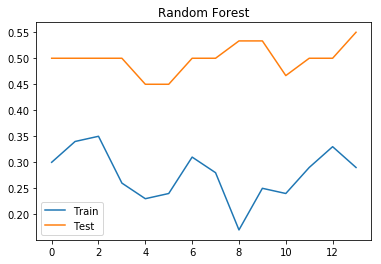

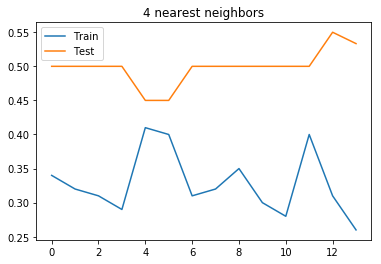

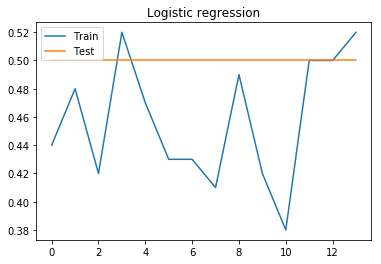

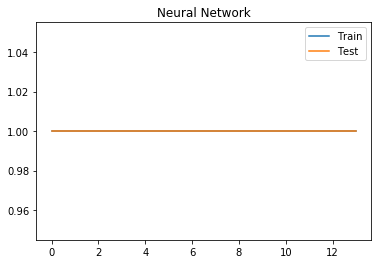

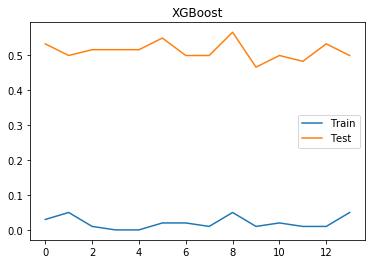

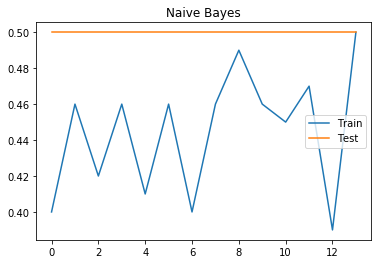

In [7]:
plt.plot(rando_train_err,label="Train")
plt.plot(rando_test_err,label="Test")
plt.title("Random Forest")
plt.legend()
plt.show()

plt.plot(knn_train_err,label="Train")
plt.plot(knn_test_err,label="Test")
plt.title("4 nearest neighbors")
plt.legend()
plt.show()

plt.plot(reg_train_err,label="Train")
plt.plot(reg_test_err,label="Test")
plt.title("Logistic regression")
plt.legend()
plt.show()

plt.plot(nn_train_err,label="Train")
plt.plot(nn_test_err,label="Test")
plt.title("Neural Network")
plt.legend()
plt.show()

plt.plot(xgb_train_err,label="Train")
plt.plot(xgb_test_err,label="Test")
plt.title("XGBoost")
plt.legend()
plt.show()

plt.plot(nb_train_err,label='Train')
plt.plot(nb_test_err,label='Test')
plt.legend()
plt.title("Naive Bayes")
plt.show()
